In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

In [5]:
accuracy = {
    "bow": [0.3357, 0.343, 0.3281],
    "cbow": [0.376, 0.34494, 0.3557],
    "deepcbow": [0.395, 0.3819, 0.3611],
    "deepcbow_pt": [0.4235, 0.4312, 0.4176],
    "lstm": [0.4774, 0.4706, 0.4765],
    "lstm_ft": [0.476, 0.4601, 0.4773],
    "tree_lstm": [0.4733, 0.4696, 0.4656],
    "tree_lstm_subtrees": [0.4733, 0.4696, 0.4656],
    "tree_lstm_childsum": [0.4733, 0.4696, 0.4656],
    "tree_lstm_childsum_subtrees": [0.4733, 0.4696, 0.4656],
    "roberta": [0.5561, 0.5451, 0.5471],
}

df = (pd.DataFrame(accuracy) * 100).T.agg(["mean", "std"], axis=1)
df["mean"] = df["mean"].round(1).astype(str) + df["std"].round(1).apply(
    lambda x: f" ({x})"
)
df.drop("std", axis=1, inplace=True)
df.index = ["BoW", "CBOW", "DeepCBOW",
            "DeepCBOW-PT", "LSTM", "LSTM-FT", "TreeLSTM", "TreeLSTM (Subtrees)", "TreeLSTM Child-sum", "TreeLSTM Child-sum (Subtrees)", "RoBERTa-base"]
df.reset_index(inplace=True)
df.columns = ["Model", "Accuracy"]
str_repr = df.style.re.hide().to_latex(
    hrules=True,
    column_format="lc",
    label="tab:results",
    position="thbp",
    position_float="centering",
)

# Add caption manually at the end
caption = """\\caption{Test set accuracies on the Stanford Sentiment Treebank. For our experiments, we report mean accuracies over 3 runs (standard deviations
in parentheses) for the fine-grained 5-class sentiment classification task.}"""

# Add caption to the end of the table
str_repr = str_repr.replace("\\end{table}", caption + "\n\\end{table}")
print(str_repr)

\begin{table}[thbp]
\centering
\label{tab:results}
\begin{tabular}{lc}
\toprule
Model & Accuracy \\
\midrule
BoW & 33.6 (0.7) \\
CBOW & 35.9 (1.6) \\
DeepCBOW & 37.9 (1.7) \\
DeepCBOW-PT & 42.4 (0.7) \\
LSTM & 47.5 (0.4) \\
LSTM-FT & 47.1 (1.0) \\
Tree-LSTM & 46.9 (0.4) \\
\bottomrule
\end{tabular}
\caption{Test set accuracies on the Stanford Sentiment Treebank. For our experiments, we report mean accuracies over 3 runs (standard deviations
in parentheses) for the fine-grained 5-class sentiment classification task.}
\end{table}



In [21]:
architectures = {
    "BOW": {"$|d|$": 5, "h": 0, "$\\theta$": 82910},
    "CBOW": {"$|d|$": 300, "h": 0, "$\\theta$": 4944500},
    # uses two hidden layers of 100 units each: [100,100]
    "DeepCBOW": {
        "$|d|$": 300,
        "h": [100, 100],
        "$\\theta$": 5015005,
    },
    "DeepCBOW-PT": {
        "$|d|$": 300,
        "h": [100, 100],
        "$\\theta$": 40650,
    },
    "LSTM": {
        "$|d|$": 300,
        "h": 150,
        "$\\theta$": 270910,
    },
    "LSTM-FT": {
        "$|d|$": 300,
        "h": 150,
        "$\\theta$": 6490055,
    },
    "TreeLSTM": {"$|d|$": 300, "$\\theta$": 6534905, "h": 150},
    "RoBERTa-base": {"$|d|$": 768, "$\\theta$": 124647424, "h": 512},
}

architecture_df = pd.DataFrame(architectures).T

arch_str = (
    architecture_df.reset_index()
    .rename(columns={"index": "Model"})
    .style.hide()
    .format(thousands=",")
    .to_latex(
        hrules=True,
        label="tab:architectures",
        column_format="lccr",
        position="thbp",
        position_float="centering",
    )
)

capt = """\\caption{Overview for each model: $|d|$ denotes the dimensionality of the word embeddings; $h$ - the hidden dimensionality; and $\\theta$ - the total number of \\textit{trainable} parameters.}"""

arch_str = arch_str.replace("\\end{table}", capt + " \n\\end{table}")

print(arch_str)

\begin{table}[thbp]
\centering
\label{tab:architectures}
\begin{tabular}{lccr}
\toprule
Model & $|d|$ & h & $\theta$ \\
\midrule
BOW & 5 & 0 & 82,910 \\
CBOW & 300 & 0 & 4,944,500 \\
DeepCBOW & 300 & [100, 100] & 5,015,005 \\
DeepCBOW-PT & 300 & [100, 100] & 40,650 \\
LSTM & 300 & 150 & 270,910 \\
LSTM-FT & 300 & 150 & 6,490,055 \\
TreeLSTM & 300 & 150 & 6,534,905 \\
RoBERTa-base & 768 & 512 & 124,647,424 \\
\bottomrule
\end{tabular}
\caption{Overview for each model: $|d|$ denotes the dimensionality of the word embeddings; $h$ - the hidden dimensionality; and $\theta$ - the total number of \textit{trainable} parameters.} 
\end{table}



In [9]:
from bow import BOWLightning
from cbow import CBOWLightning
from deepcbow import DeepCBOWLightning
from lstm import LSTMLightning
from treelstm import TreeLSTMLightning

from utils import SST_PL
from torch import nn
import torch
from pytorch_lightning import Trainer

dataset = SST_PL(lower=True)
dataset.prepare_data()

In [10]:
def test_model(model, dataset):
    test_dict = {}
    model.eval()
    with torch.no_grad():
        for batch in dataset.test_dataloader():
            x, y = batch
            y_hat = model(x)
            accuracies = (y_hat.argmax(dim=1) == y).float()
            for i in range(len(x)):
                len_sent = torch.count_nonzero(x[i] != 1).item()
                test_dict[len_sent] = test_dict.get(len_sent, []) + [
                    accuracies[i].item()
                ]
    test_dict = {k: np.mean(v) for k, v in test_dict.items()}
    return test_dict


bow = BOWLightning.load_from_checkpoint(
    "/Users/Matey/Documents/Obsidian/University/Courses/NLP/Practicals/data/save/checkpoints/BOW-epoch=25-val_loss=2.88-val_acc=0.32.ckpt",
    vocab=dataset.vocab,
)
bow_dict = test_model(bow.model, dataset)
bow_dict

bias                     [5]          requires_grad=True
embed.weight             [16581, 5]   requires_grad=True

Total number of parameters: 82910


{4: 0.2,
 21: 0.2972972972972973,
 23: 0.3010752688172043,
 26: 0.3230769230769231,
 9: 0.34328358208955223,
 20: 0.30120481927710846,
 22: 0.39080459770114945,
 7: 0.31343283582089554,
 14: 0.34177215189873417,
 15: 0.41935483870967744,
 13: 0.4,
 24: 0.325,
 10: 0.352112676056338,
 12: 0.3076923076923077,
 6: 0.2807017543859649,
 8: 0.3979591836734694,
 17: 0.3263157894736842,
 11: 0.3939393939393939,
 37: 0.35294117647058826,
 16: 0.26666666666666666,
 19: 0.38461538461538464,
 29: 0.36538461538461536,
 33: 0.3684210526315789,
 18: 0.24271844660194175,
 42: 0.2,
 38: 0.3684210526315789,
 25: 0.3939393939393939,
 27: 0.3382352941176471,
 31: 0.42105263157894735,
 40: 0.5555555555555556,
 34: 0.08695652173913043,
 35: 0.3888888888888889,
 36: 0.35,
 28: 0.19642857142857142,
 32: 0.16666666666666666,
 56: 0.0,
 5: 0.45454545454545453,
 41: 0.16666666666666666,
 39: 0.1,
 30: 0.47058823529411764,
 43: 0.2857142857142857,
 44: 0.6,
 48: 0.6666666666666666,
 2: 0.16666666666666666,
 3: 0.

In [11]:
def put_in_bins(data: dict, k):
    def create_bins(data, k):
        start = min(data)
        end = max(data)  # Adjust as needed
        return [(i, i + k - 1) for i in range(start, end, k)]

    # Create the bins
    bins = create_bins(data.keys(), k)

    # Initialize the bin data
    bin_data = {bin: {"sum": 0, "count": 0} for bin in bins}

    # Iterate over the items in the original dictionary
    for key, value in data.items():
        # Determine which bin this item belongs to
        for bin in bins:
            if bin[0] <= key < bin[1]:
                # Add the value to the sum for this bin and increment the count
                bin_data[bin]["sum"] += value
                bin_data[bin]["count"] += 1
                break

    # Calculate the average for each bin
    return {
        bin: data["sum"] / data["count"] if data["count"] > 0 else 0
        for bin, data in bin_data.items()
    }

In [12]:
cbow_model = CBOWLightning.load_from_checkpoint(
    "/Users/Matey/Documents/Obsidian/University/Courses/NLP/Practicals/data/save/checkpoints/CBOW-epoch=3-val_loss=2.80-val_acc=0.35.ckpt",
    vocab=dataset.vocab,
)

cbow_dict = test_model(cbow_model.model, dataset)
cbow_dict

embed.weight             [16581, 300] requires_grad=True
linear.weight            [5, 300]     requires_grad=True
linear.bias              [5]          requires_grad=True

Total number of parameters: 4975805


{4: 0.25,
 21: 0.36486486486486486,
 23: 0.3010752688172043,
 26: 0.36923076923076925,
 9: 0.47761194029850745,
 20: 0.40963855421686746,
 22: 0.41379310344827586,
 7: 0.3283582089552239,
 14: 0.25316455696202533,
 15: 0.3333333333333333,
 13: 0.4117647058823529,
 24: 0.3,
 10: 0.3380281690140845,
 12: 0.34615384615384615,
 6: 0.5087719298245614,
 8: 0.3877551020408163,
 17: 0.4,
 11: 0.42424242424242425,
 37: 0.23529411764705882,
 16: 0.3466666666666667,
 19: 0.4725274725274725,
 29: 0.38461538461538464,
 33: 0.3684210526315789,
 18: 0.32038834951456313,
 42: 0.2,
 38: 0.42105263157894735,
 25: 0.3787878787878788,
 27: 0.4117647058823529,
 31: 0.39473684210526316,
 40: 0.2222222222222222,
 34: 0.5217391304347826,
 35: 0.3333333333333333,
 36: 0.4,
 28: 0.2857142857142857,
 32: 0.43333333333333335,
 56: 0.0,
 5: 0.45454545454545453,
 41: 0.3333333333333333,
 39: 0.4,
 30: 0.5,
 43: 0.2857142857142857,
 44: 0.0,
 48: 0.6666666666666666,
 2: 0.16666666666666666,
 3: 0.6153846153846154,
 

In [13]:
deepcbow = DeepCBOWLightning.load_from_checkpoint(
    "/Users/Matey/Documents/Obsidian/University/Courses/NLP/Practicals/data/save/checkpoints/DeepCBOW-epoch=1-val_loss=1.43-val_acc=0.38.ckpt", vocab=dataset.vocab)

deepcbow_dict = test_model(deepcbow.model, dataset)
np.mean(list(deepcbow_dict.values()))

embed.weight             [16581, 300] requires_grad=True
layers.0.weight          [100, 300]   requires_grad=True
layers.0.bias            [100]        requires_grad=True
layers.2.weight          [100, 100]   requires_grad=True
layers.2.bias            [100]        requires_grad=True
layers.3.weight          [5, 100]     requires_grad=True
layers.3.bias            [5]          requires_grad=True

Total number of parameters: 5015005


0.38345411113059313

In [14]:
from utils import initialize_vocabulary, load_embeddings

vocab, vectors = initialize_vocabulary(load_embeddings("glove"))
dataset_glove = SST_PL(lower=True, vocab=vocab)
dataset_glove.prepare_data()

deepcbow_pt = DeepCBOWLightning.load_from_checkpoint(
    "/Users/Matey/Documents/Obsidian/University/Courses/NLP/Practicals/data/save/checkpoints/DeepCBOW__pt-epoch=28-val_loss=1.43-val_acc=0.44.ckpt",
    vocab=dataset_glove.vocab,
)
deepcbow_pt_dict = test_model(deepcbow_pt.model, dataset_glove)
np.mean(list(deepcbow_pt_dict.values()))

embed.weight             [20727, 300] requires_grad=True
layers.0.weight          [100, 300]   requires_grad=True
layers.0.bias            [100]        requires_grad=True
layers.2.weight          [100, 100]   requires_grad=True
layers.2.bias            [100]        requires_grad=True
layers.3.weight          [5, 100]     requires_grad=True
layers.3.bias            [5]          requires_grad=True

Total number of parameters: 6258805


0.4096274508403303

In [15]:
lstm = LSTMLightning.load_from_checkpoint(
    "/Users/Matey/Documents/Obsidian/University/Courses/NLP/Practicals/data/save/checkpoints/LSTMClassifier-epoch=2-val_loss=1.23-val_acc=0.48.ckpt", vocab=dataset_glove.vocab, vectors=vectors)

lstm_dict = test_model(lstm.model, dataset_glove)
np.mean(list(lstm_dict.values()))

rnn.linear_ii.weight     [150, 300]   requires_grad=True
rnn.linear_ii.bias       [150]        requires_grad=True
rnn.linear_hi.weight     [150, 150]   requires_grad=True
rnn.linear_hi.bias       [150]        requires_grad=True
rnn.linear_if.weight     [150, 300]   requires_grad=True
rnn.linear_if.bias       [150]        requires_grad=True
rnn.linear_hf.weight     [150, 150]   requires_grad=True
rnn.linear_hf.bias       [150]        requires_grad=True
rnn.linear_ig.weight     [150, 300]   requires_grad=True
rnn.linear_ig.bias       [150]        requires_grad=True
rnn.linear_hg.weight     [150, 150]   requires_grad=True
rnn.linear_hg.bias       [150]        requires_grad=True
rnn.linear_io.weight     [150, 300]   requires_grad=True
rnn.linear_io.bias       [150]        requires_grad=True
rnn.linear_ho.weight     [150, 150]   requires_grad=True
rnn.linear_ho.bias       [150]        requires_grad=True
output_layer.1.weight    [5, 150]     requires_grad=True
output_layer.1.bias      [5]   

0.4817812111313747

In [17]:
from utils import SST_TreePL


def test_model_tree(model, dataset):
    test_dict = {}
    model.eval()
    with torch.no_grad():
        for batch in dataset.test_dataloader():
            x, y = batch
            y_hat = model(x)
            accuracies = (y_hat.argmax(dim=1) == y).float()
            for i in range(len(x)):
                len_sent = torch.count_nonzero(x[0][i] != 1).item()
                test_dict[len_sent] = test_dict.get(len_sent, []) + [
                    accuracies[i].item()
                ]
    test_dict = {k: np.mean(v) for k, v in test_dict.items()}
    return test_dict


tree_dataset = SST_TreePL(lower=True, vocab=vocab)
tree_dataset.prepare_data()

tree_lstm = TreeLSTMLightning.load_from_checkpoint(
    "/Users/Matey/Documents/Obsidian/University/Courses/NLP/Practicals/data/save/checkpoints/TreeLSTMClassifier-epoch=18-val_loss=1.45-val_acc=0.47.ckpt",
    vocab=tree_dataset.vocab,
    vectors=vectors,
)

tree_lstm_dict = test_model_tree(tree_lstm.model, tree_dataset)
np.mean(list(tree_lstm_dict.values()))

treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treelstm.proj_x_gate.bias [150]        requires_grad=True
output_layer.1.weight    [5, 150]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True
embed.weight             [20727, 300] requires_grad=False

Total number of parameters: 6534905


0.5191548691548691

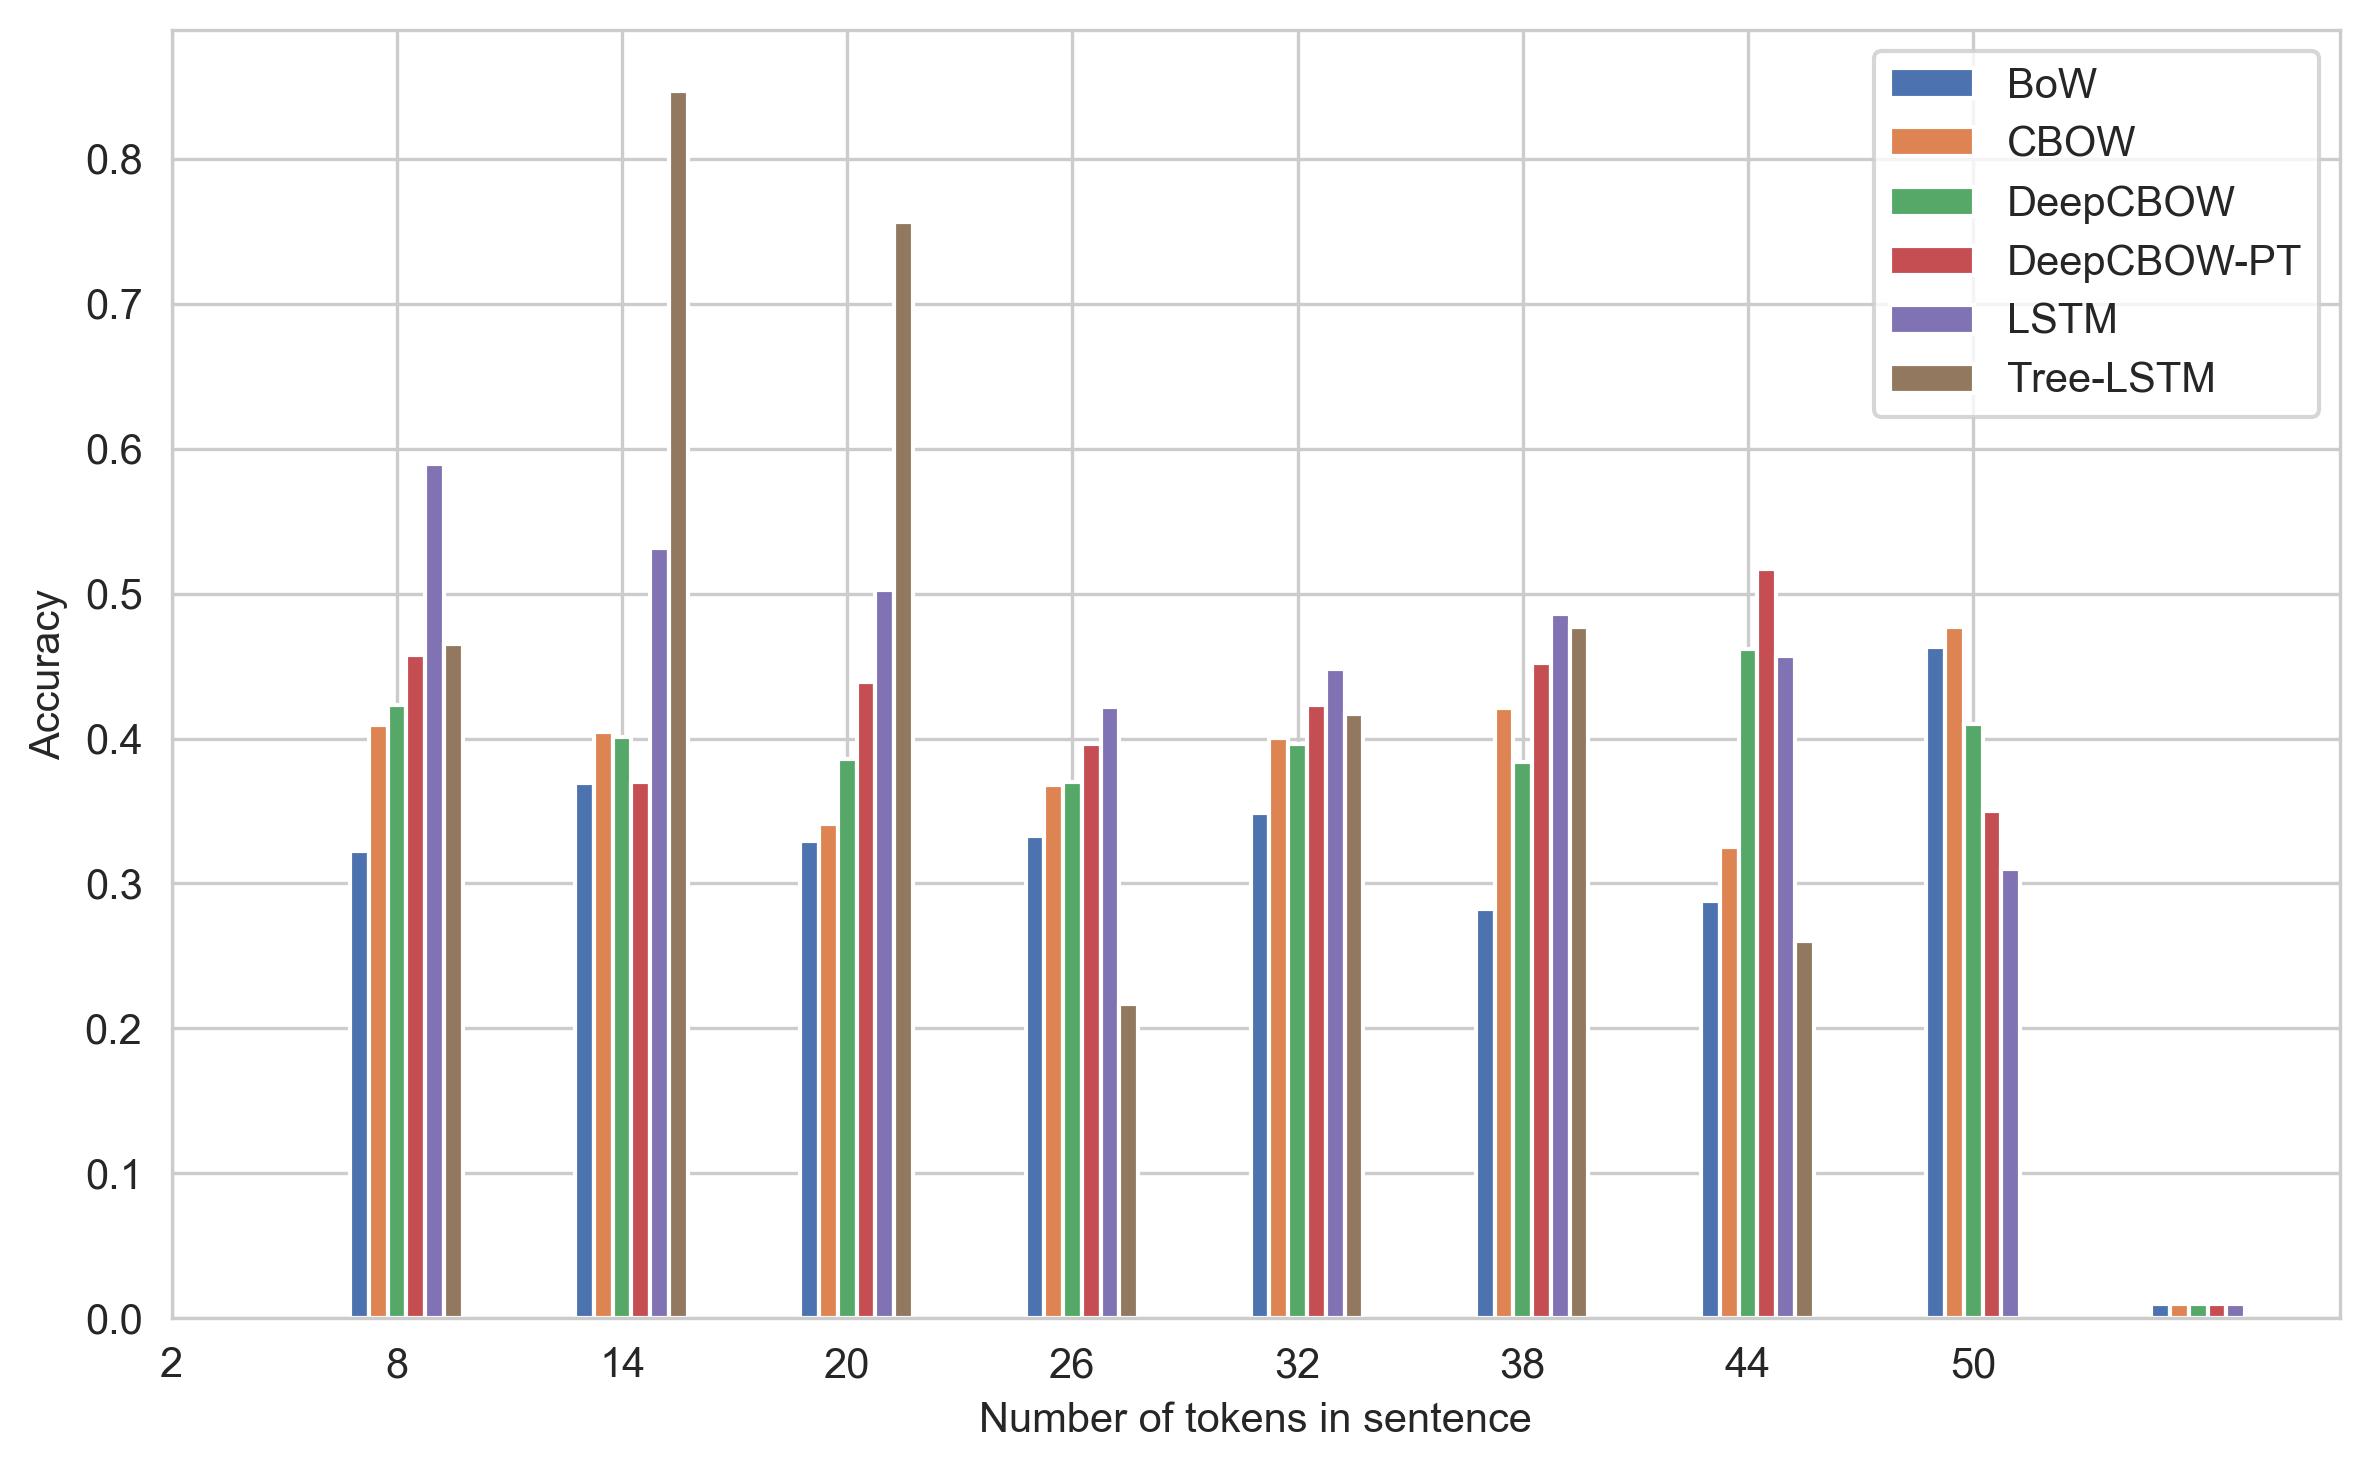

In [33]:
sns.set_palette("deep")

k = 6
bin_averages_bow = put_in_bins(bow_dict, k)
bin_averages_cbow = put_in_bins(cbow_dict, k)
bin_averages_deepcbow = put_in_bins(deepcbow_dict, k)
bin_averages_deepcbow_pt = put_in_bins(deepcbow_pt_dict, k)
bin_averages_lstm = put_in_bins(lstm_dict, k)
bin_averages_tree_lstm = put_in_bins(tree_lstm_dict, k)

labels = ["BoW", "CBOW", "DeepCBOW", "DeepCBOW-PT", "LSTM", "Tree-LSTM"]

plt.figure(figsize=(8, 5),dpi=300)
for i, bin_averages in enumerate([
    bin_averages_bow,
    bin_averages_cbow,
    bin_averages_deepcbow,
    bin_averages_deepcbow_pt,
    bin_averages_lstm,
]):
    x = np.array([a[1] for a in bin_averages.keys()]) + i * 0.5
    y = np.array(list(bin_averages.values())) + 0.01
    plt.bar(x,y,width=0.5, label=labels[i])
    
plt.bar(np.array([a[1] for a in bin_averages_tree_lstm.keys()]) - 1 + 5 * 0.5, np.array(list(bin_averages_tree_lstm.values())) + 0.01, width=0.5, label="Tree-LSTM")
plt.xticks(range(list(bin_averages.keys())[0][0], list(bin_averages.keys())[-1][-1], k))
plt.xlabel("Number of tokens in sentence")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend()
# plt.xlim(bins[0][0], bins[-1][-1])

plt.savefig("save/sent_length_accuracy.png")